In [5]:
!pip install --upgrade git+https://github.com/kieferk/pymssa.git@master

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kieferk/pymssa.git (to revision master) to /tmp/pip-req-build-9khdqyhg
  Running command git clone --filter=blob:none --quiet https://github.com/kieferk/pymssa.git /tmp/pip-req-build-9khdqyhg
  Resolved https://github.com/kieferk/pymssa.git to commit 9d4d3e2c317ef64d0604796cf3fbdf9b5dc8e7fe
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 KB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 7.5 MB/s eta 0:00:00
  Created wheel for pymssa: filename=pymssa-0.1.0-py3-none-any.whl size=13866 sha256=98e5fe92eb6e5d98cc374c7dbf895604a7f686bb8f49d79468313f5067ebe287
  Stored in directory: /tmp/pip-ephem-wheel-cache-p549fg81/wheels/6f/b4/5f/0972c0a2e208e4b4be261eb78d37028ab4b31e0a841aadc1ed
Successfully built pyms

In [9]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

### Прогнозирование набора временных рядов с помощью MSSA из pymssa

In [10]:
from tqdm.autonotebook import tqdm
from pymssa import MSSA 

/tmp/ipykernel_4668/803740092.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [32]:
def make_sine_2sine_ts(n_points, dimension=1, n_periods=4, ampl=10, period_ratio=1/5):
    sigma = ampl / 10
    time = np.arange(1, n_points+1)
    series_1 = (ampl / 2) * np.sin(np.tile(time * 2 * np.pi * n_periods / n_points, (dimension, 1)).T)
    series_2 = (ampl / 2) * np.sin(np.tile(time * 2 * np.pi * n_periods / period_ratio / n_points, (dimension, 1)).T)
    series_2sines = series_1 + series_2 + sigma * np.random.randn(n_points, dimension)
    series_sine = ampl * np.sin(np.tile(time * 2 * np.pi * n_periods / n_points, (dimension, 1)).T) + sigma * np.random.randn(n_points, dimension)
    table = np.column_stack((series_sine, series_2sines))
    column_names = ['Sine'] + ['2Sines']
    ts = pd.DataFrame(table, columns=column_names)
    return ts

In [33]:
ts = make_sine_2sine_ts(1000)

In [34]:
ts.head()

,Sine,2Sines
0,0.546970,2.702306
1,1.253121,2.152574
2,1.492533,1.846650
3,0.884226,4.558433
4,0.681940,1.542262


In [35]:
tp = 700

ts_tr = ts.iloc[:tp]
ts_te = ts.iloc[tp:]

In [36]:
mssa = MSSA(n_components=None,
            window_size=None,
            verbose=True)

In [37]:
mssa.fit(ts_tr)

Constructing trajectory matrix
Trajectory matrix shape: (700, 351)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


#### Визуализация главных компонент первого временного ряда.

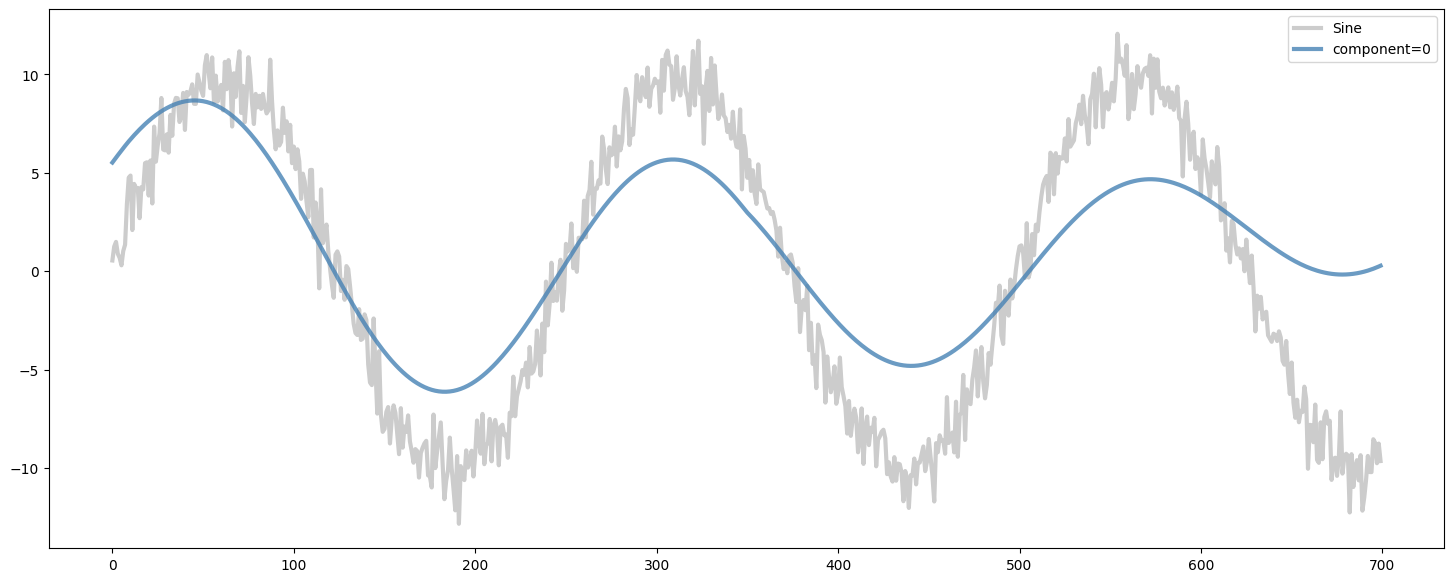

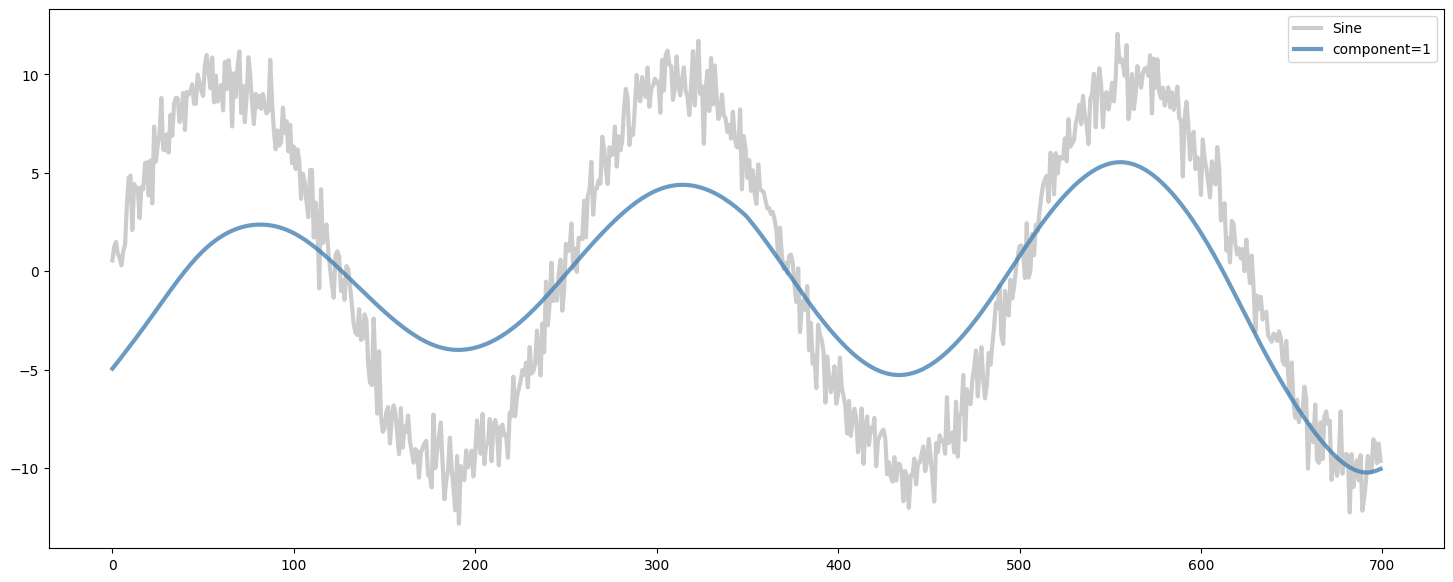

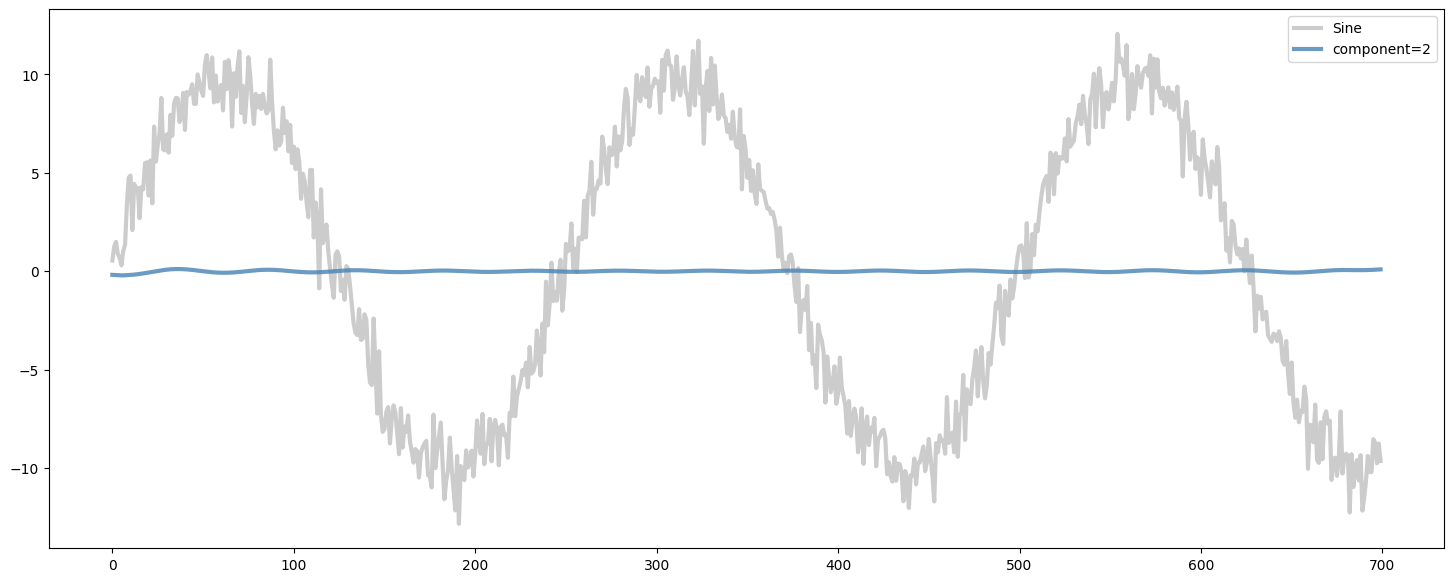

In [38]:
sine_idx = 0

for comp in range(3):  
    fig, ax = plt.subplots(figsize=(18, 7))
    ax.plot(ts_tr.index, ts_tr.iloc[:, sine_idx].values, lw=3, alpha=0.2, c='k', label=ts_tr.columns[sine_idx])
    ax.plot(ts_tr.index, mssa.components_[sine_idx, :, comp], lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    ax.legend()
    plt.show()

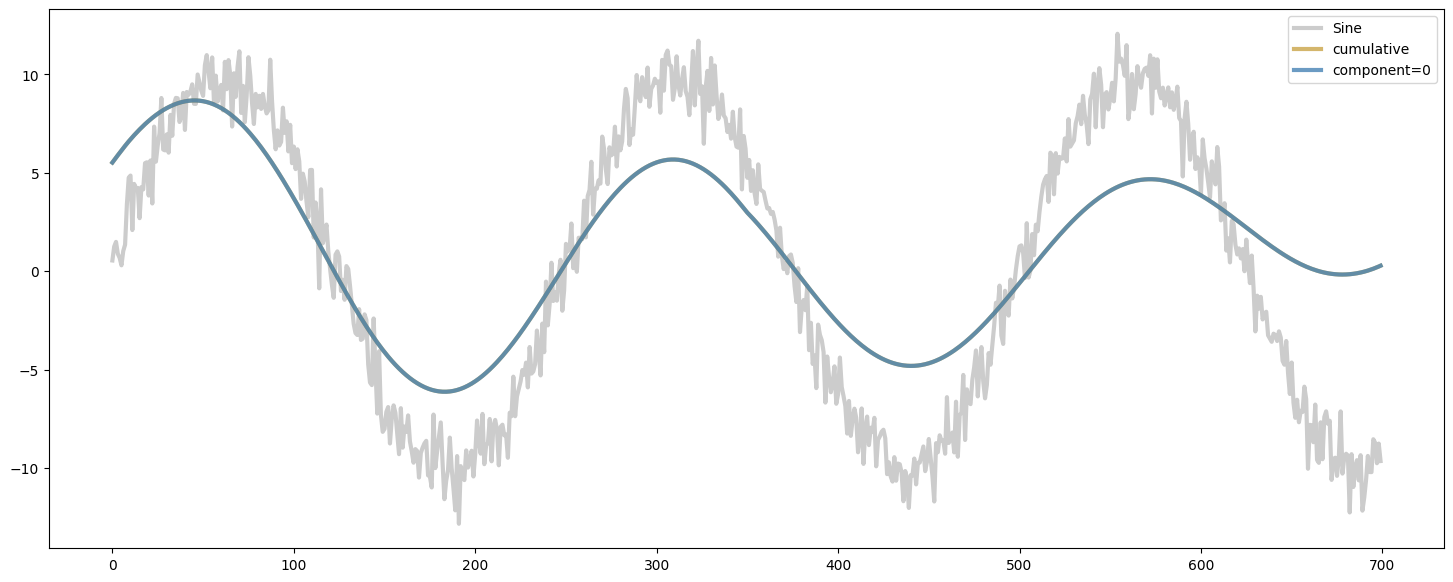

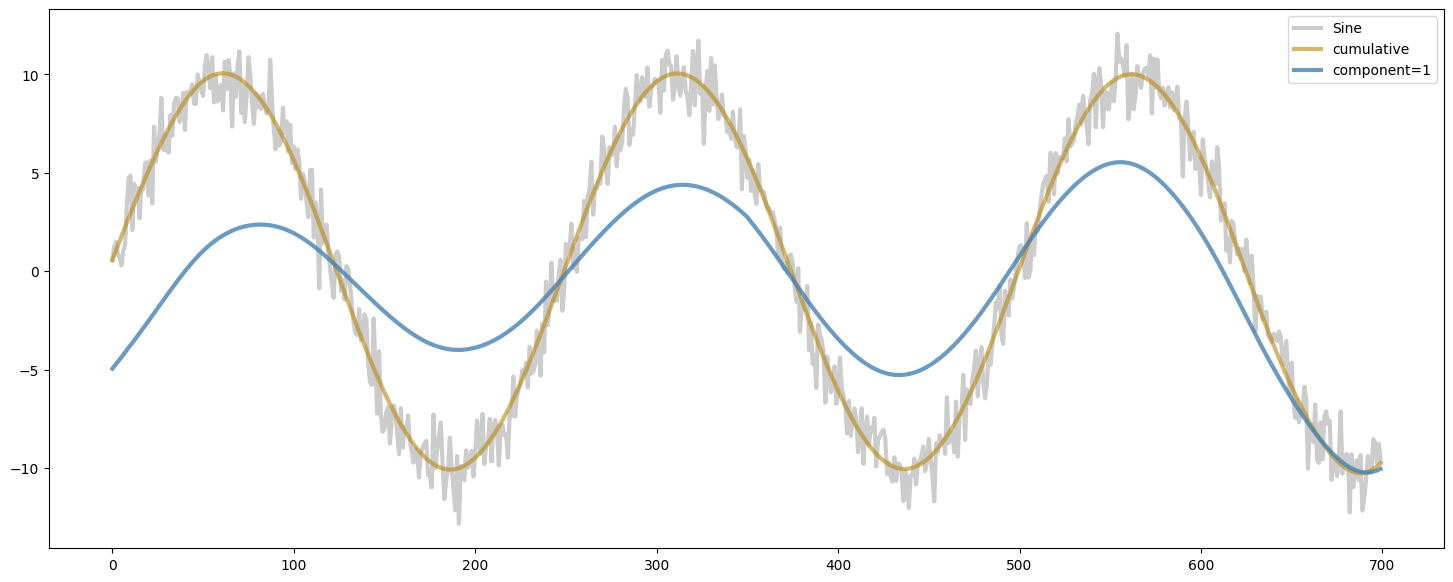

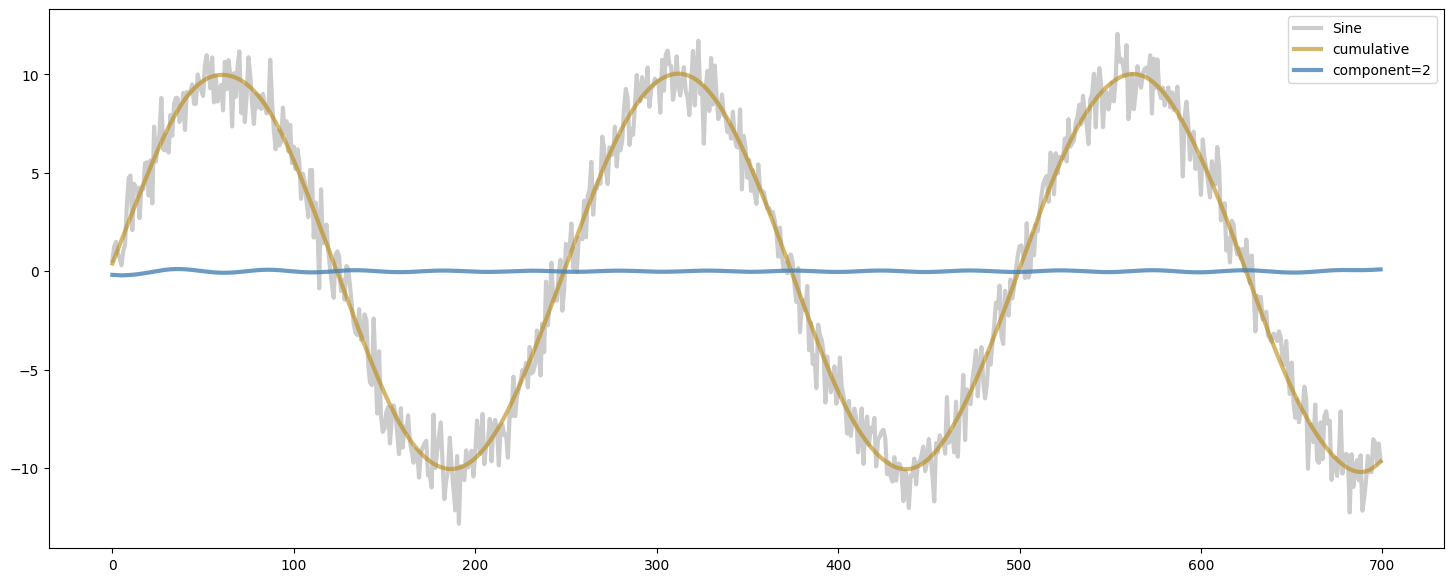

In [39]:
sine_idx = 0

cumulative_recon = np.zeros_like(ts_tr.iloc[:, sine_idx].values)

for comp in range(3):  
    fig, ax = plt.subplots(figsize=(18, 7))
    current_component = mssa.components_[sine_idx, :, comp]
    cumulative_recon = cumulative_recon + current_component
    
    ax.plot(ts_tr.index, ts_tr.iloc[:, sine_idx].values, lw=3, alpha=0.2, c='k', label=ts_tr.columns[sine_idx])
    ax.plot(ts_tr.index, cumulative_recon, lw=3, c='darkgoldenrod', alpha=0.6, label='cumulative'.format(comp))
    ax.plot(ts_tr.index, current_component, lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    
    ax.legend()
    plt.show()

#### Визуализация главных компонент второго временного ряда.

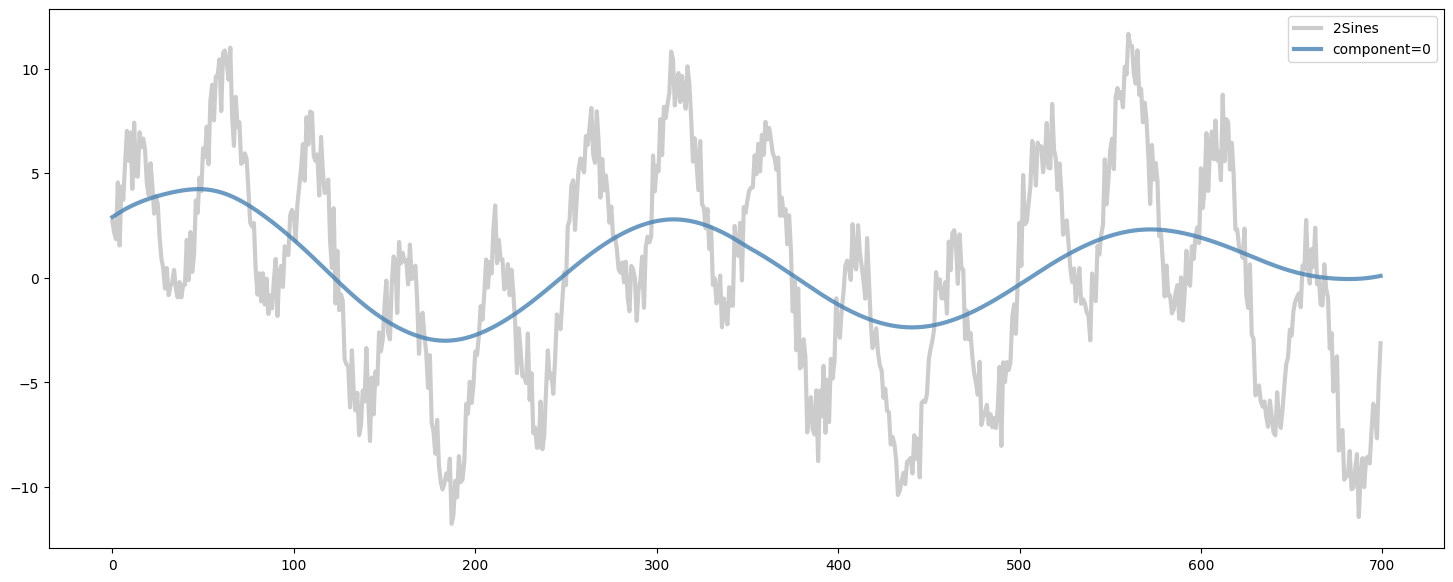

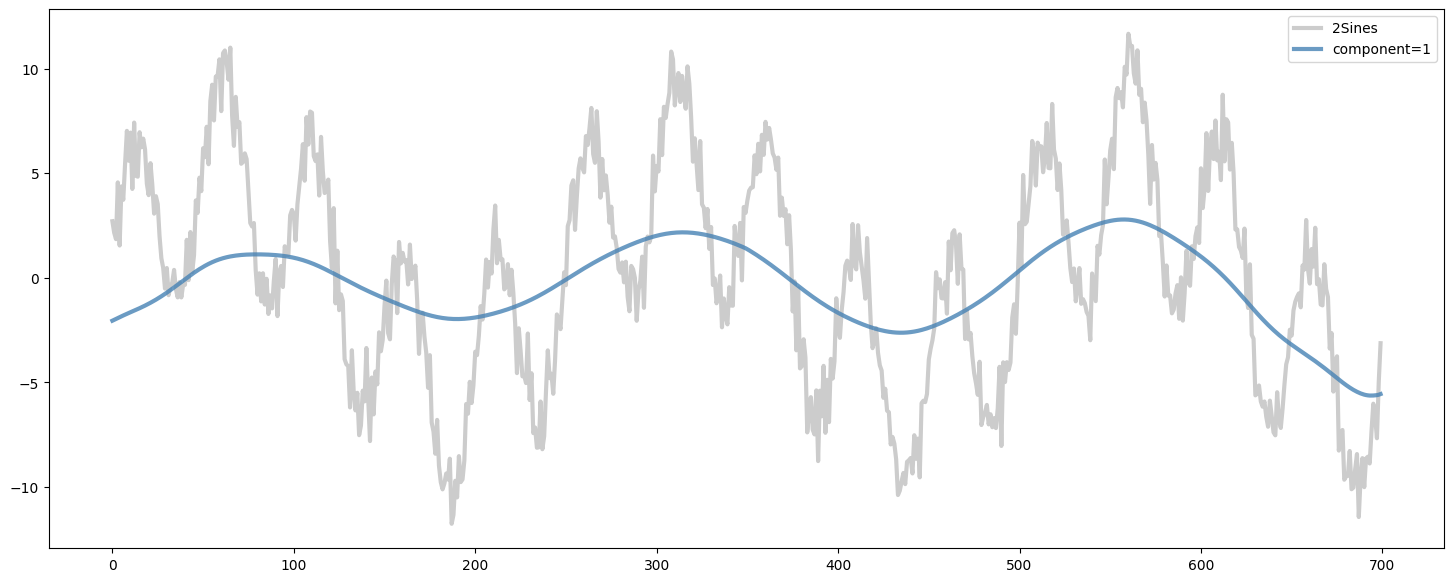

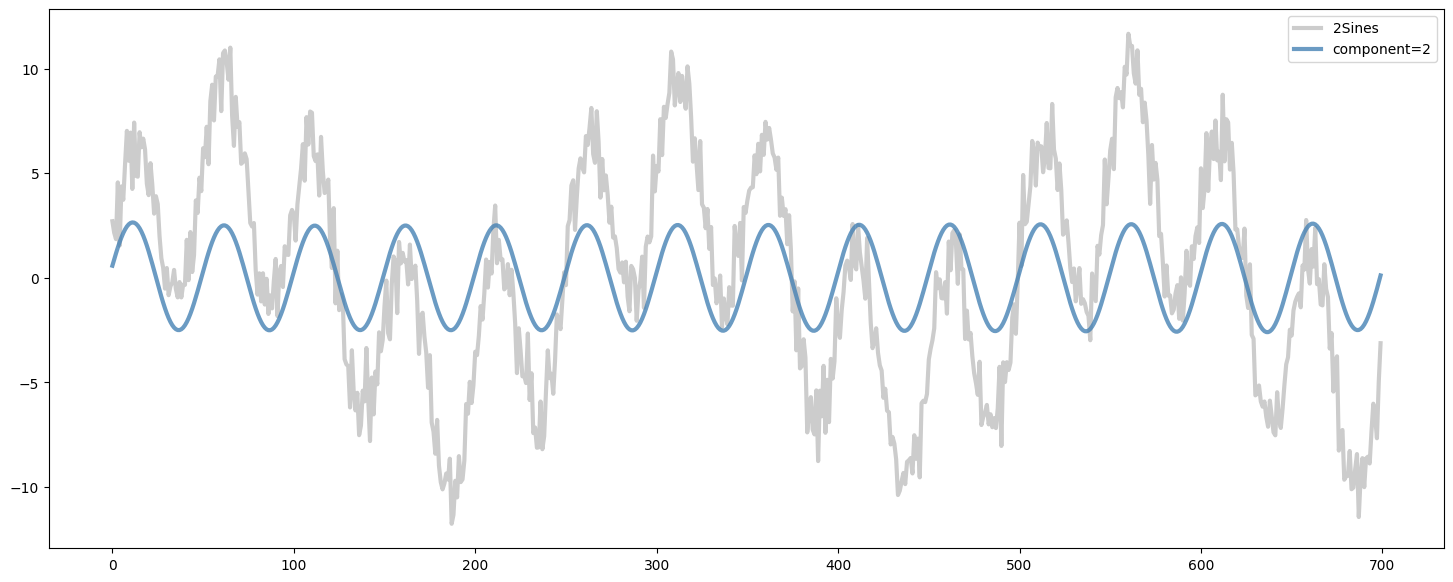

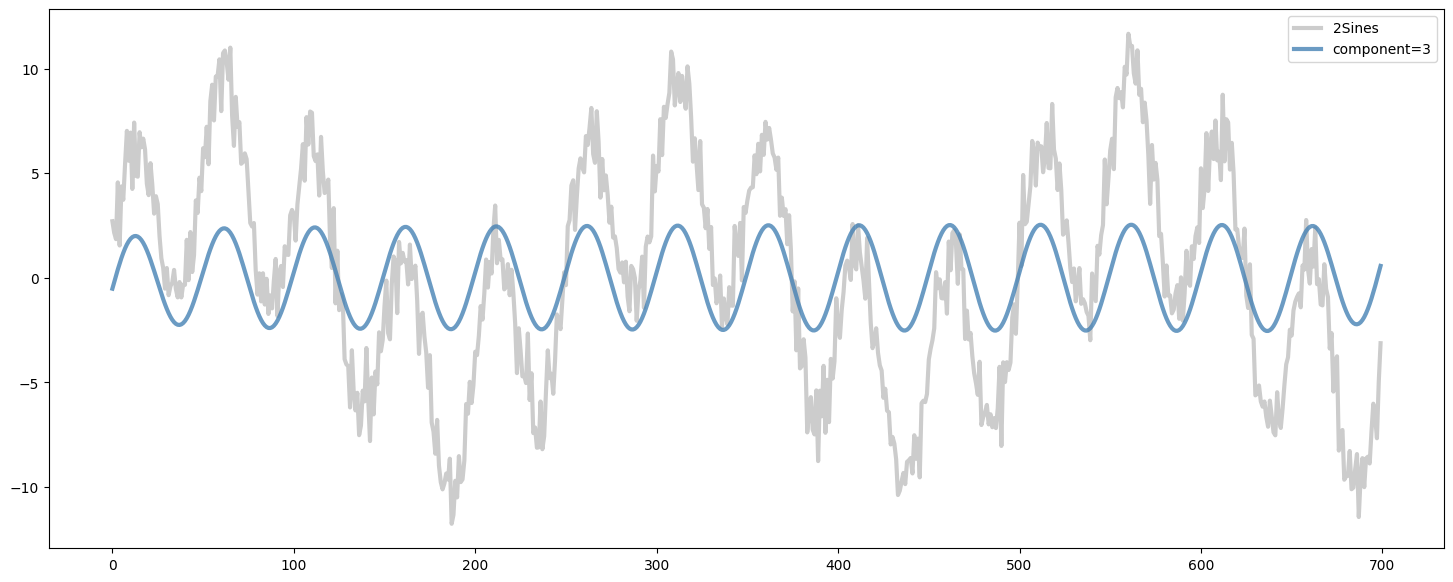

In [40]:
sine_idx = 1

for comp in range(4):  
    fig, ax = plt.subplots(figsize=(18, 7))
    ax.plot(ts_tr.index, ts_tr.iloc[:, sine_idx].values, lw=3, alpha=0.2, c='k', label=ts_tr.columns[sine_idx])
    ax.plot(ts_tr.index, mssa.components_[sine_idx, :, comp], lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    ax.legend()
    plt.show()

 #### Второй временной ряд, восстановленный по первым 4 компонентам.

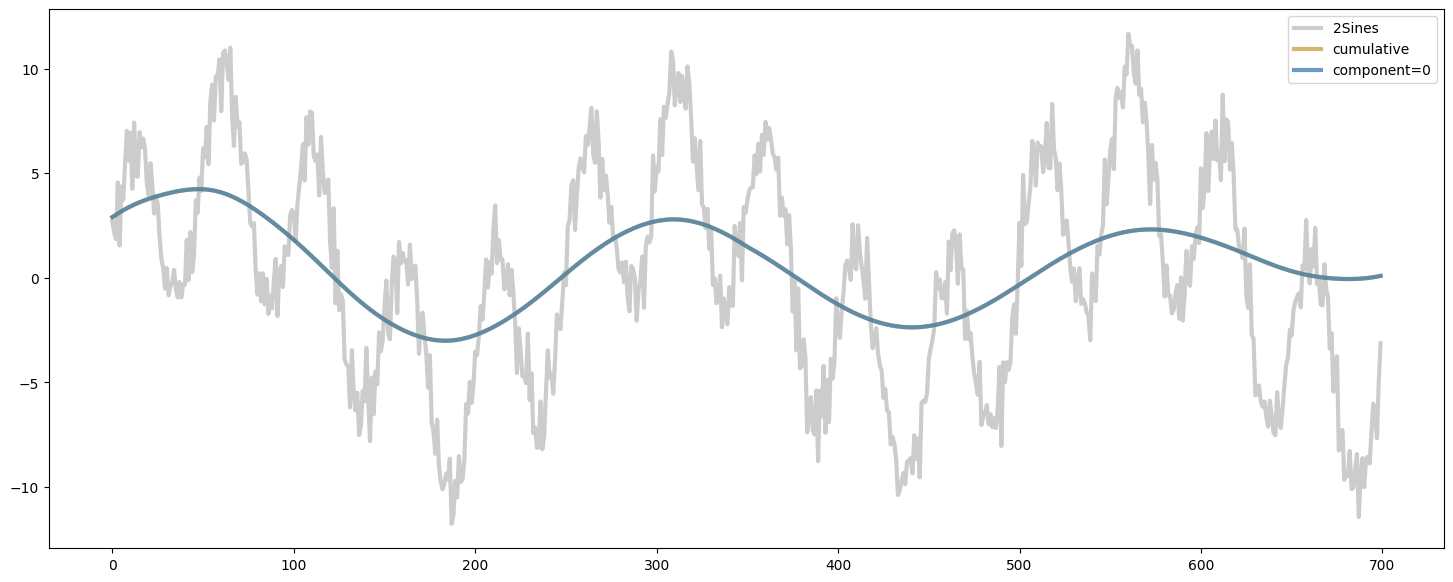

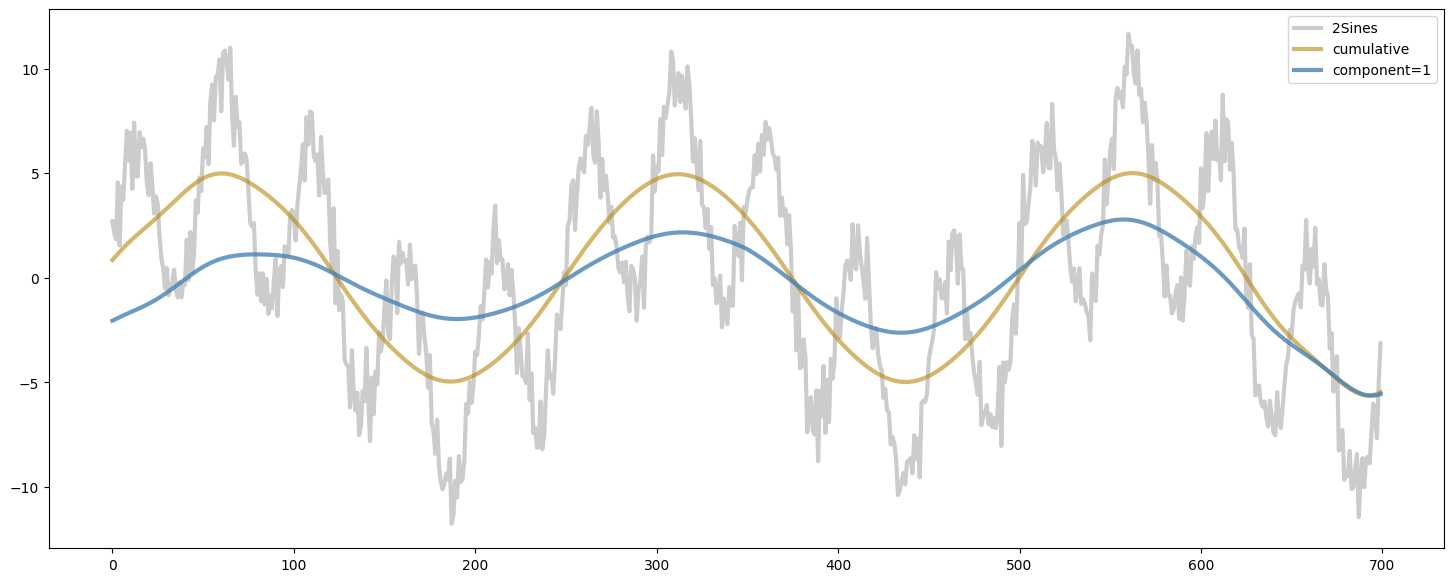

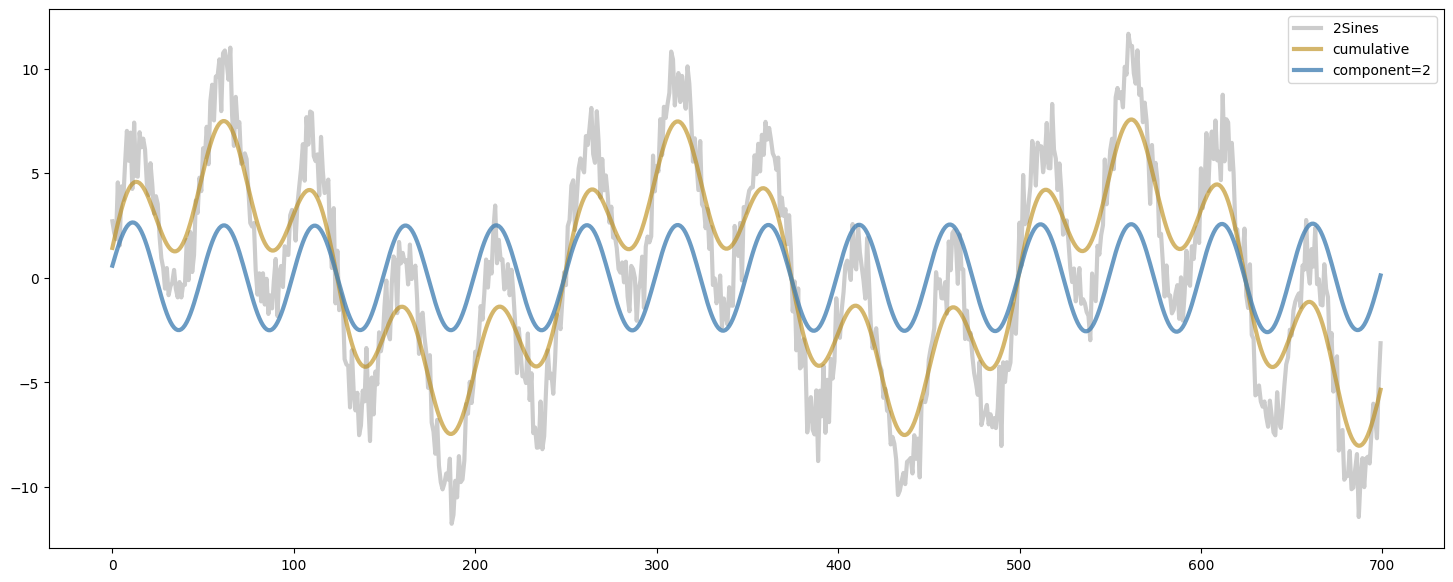

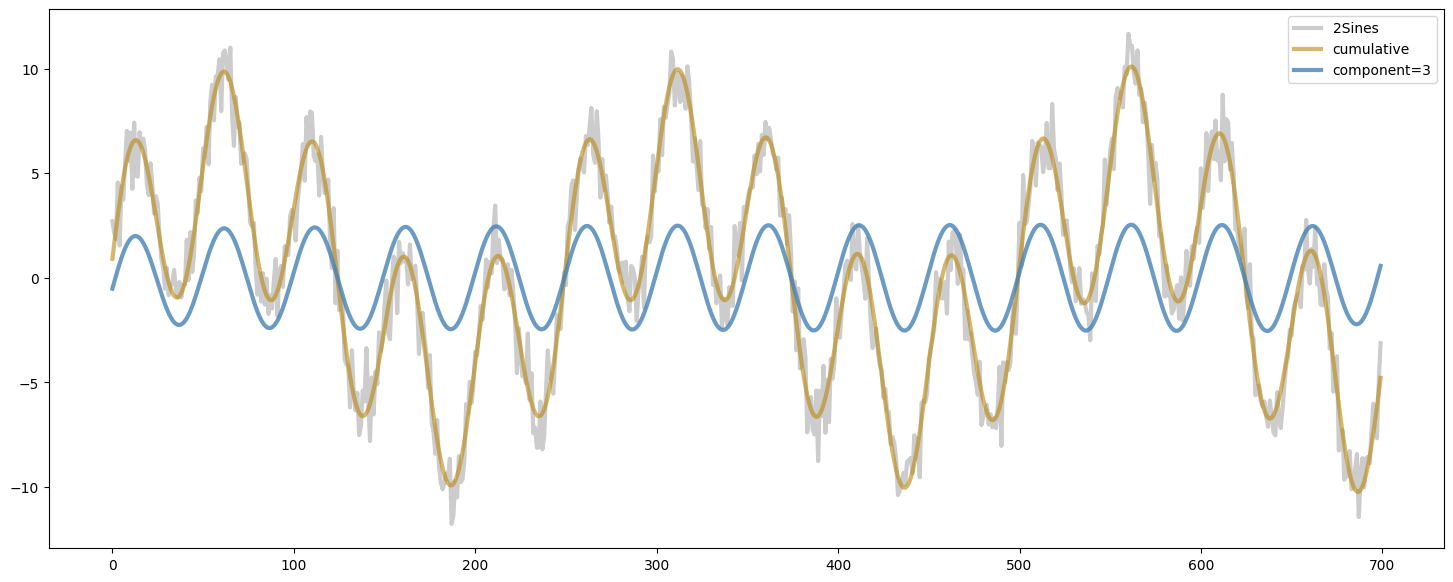

In [41]:
sine_idx = 1

cumulative_recon = np.zeros_like(ts_tr.iloc[:, sine_idx].values)

for comp in range(4):  
    fig, ax = plt.subplots(figsize=(18, 7))
    current_component = mssa.components_[sine_idx, :, comp]
    cumulative_recon = cumulative_recon + current_component
    
    ax.plot(ts_tr.index, ts_tr.iloc[:, sine_idx].values, lw=3, alpha=0.2, c='k', label=ts_tr.columns[sine_idx])
    ax.plot(ts_tr.index, cumulative_recon, lw=3, c='darkgoldenrod', alpha=0.6, label='cumulative'.format(comp))
    ax.plot(ts_tr.index, current_component, lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    
    ax.legend()
    plt.show()

#### Прогнозирование набора временных рядов с помощью MSSA.

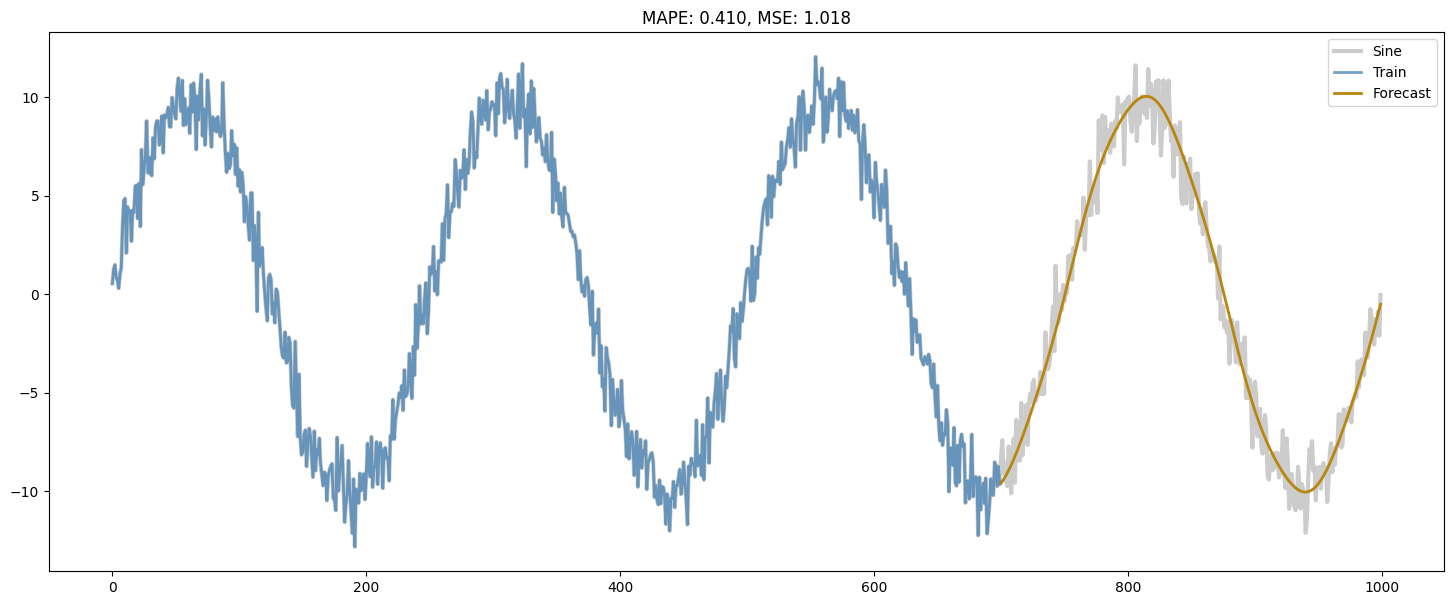

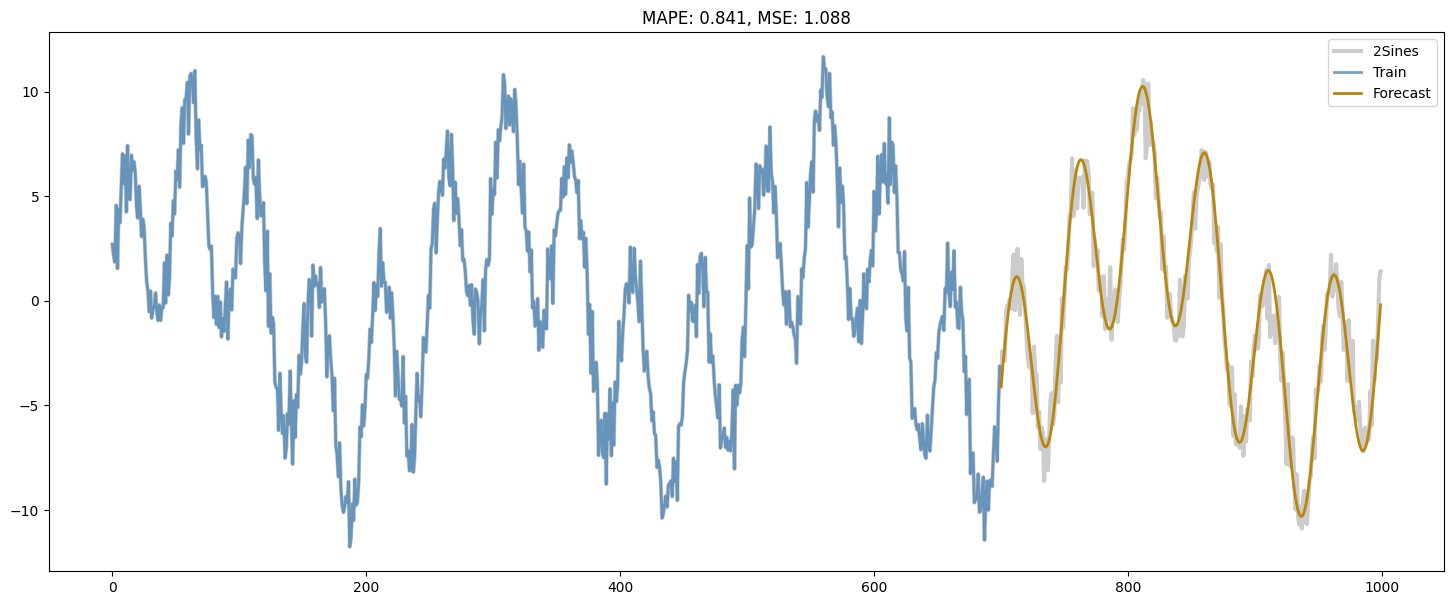

In [45]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE


for ts_index in range(ts.shape[1]):
    tr = np.zeros(ts.shape[0])
    tr[:] = np.nan

    te = np.copy(tr)

    tr[:tp] = mssa.components_[ts_index, :, :].sum(axis=1)
    fc = mssa.forecast(1000 - tp, timeseries_indices=ts_index, use_components=4)
    
    ytrue = ts_te.iloc[:, ts_index].values
    yhat = fc.ravel()[~pd.isnull(ytrue)]
    ytrue = ytrue[~pd.isnull(ytrue)]
    
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    te[tp:] = fc

    fig, ax = plt.subplots(figsize=(18, 7))
    ax.plot(ts.index, ts.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=ts.columns[ts_index])
    ax.plot(ts.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
    ax.plot(ts.index, te, lw=2, c='darkgoldenrod', label='Forecast')
    ax.set_title('MAPE: {:.3f}'.format(mape) + ', MSE: {:.3f}'.format(mse))
    ax.legend()

    plt.savefig("fig{name}".format(name=ts_index))
    
    plt.show()

### Прогнозирование при помощи ARIMA

In [90]:
!pip install statsforecast

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 1.8 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 KB 3.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.7/376.7 KB 3.7 MB/s eta 0:00:003.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 3.9 MB/s eta 0:00:00m eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 KB 3.6 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 2.0 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import AutoReg
import matplotlib.pyplot as plt

In [23]:
def make_sine_ts(n_points, dimension=1, n_periods=4, ampl=10):
    sigma = ampl / 10
    time = np.arange(1, n_points+1)
    series_sine = ampl * np.sin(np.tile(time * 2 * np.pi * n_periods / n_points, (dimension, 1)).T) + sigma * np.random.randn(n_points, dimension)
    table = np.column_stack((time, series_sine))
    column_names = ['ds', 'data']
    ts = pd.DataFrame(table, columns=column_names)
    return ts

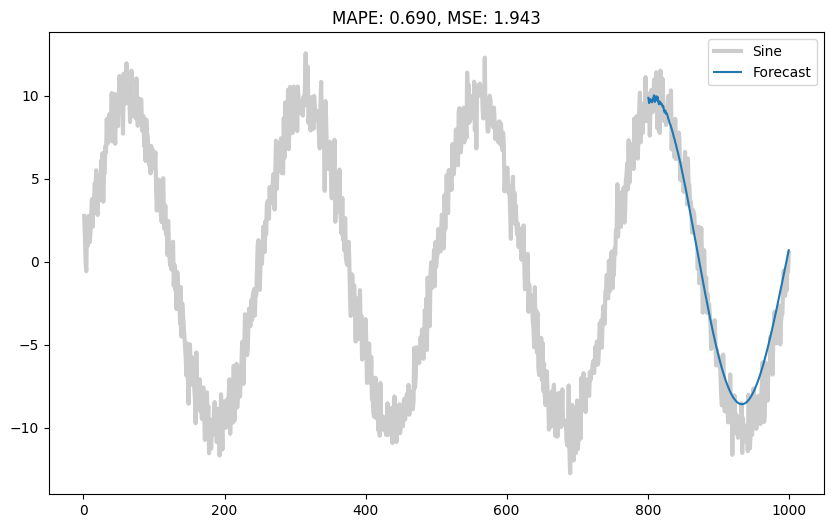

In [62]:
n = 1000

ts = make_sine_ts(n)

# Создадим случайный временной ряд


# Разобьем ряд на обучающую и тестовую выборки
ntrain = int(n * 0.8)
train_ar = ts.loc[:ntrain, 'data']
test_ar = ts.loc[ntrain:, 'data']

# Обучим модель AutoReg
lag = 30
model = AutoReg(train_ar, lags=lag)
model_fit = model.fit()

# Сделаем предсказания
predictions = model_fit.predict(start=len(train_ar), end=len(train_ar)+len(test_ar)-1)

mape = MAPE(predictions, test_ar)
mse = MSE(predictions, test_ar)

plt.figure(figsize=(10,6))
plt.plot(ts['ds'], ts['data'], lw=3, alpha=0.2, c='k', label='Sine')
plt.plot(ts['ds'].tail(n - ntrain), predictions, label='Forecast')
plt.title('MAPE: {:.3f}'.format(mape) + ', MSE: {:.3f}'.format(mse))
plt.legend()
plt.savefig("figAR_1")
plt.show()

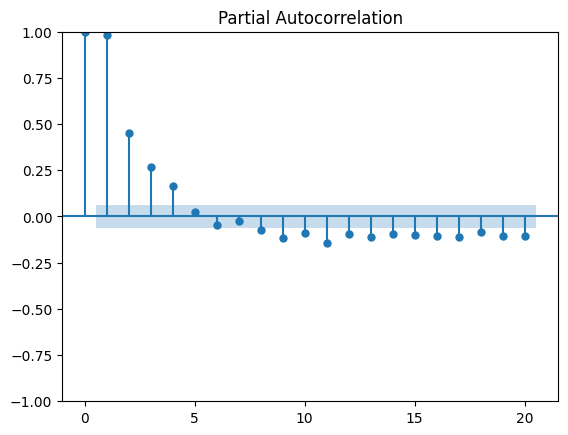

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts['data'], lags=20)
plt.show()

In [64]:
def make_2sine_ts(n_points, dimension=1, n_periods=4, ampl=10, period_ratio=1/5):
    sigma = ampl / 10
    time = np.arange(1, n_points+1)
    series_1 = (ampl / 2) * np.sin(np.tile(time * 2 * np.pi * n_periods / n_points, (dimension, 1)).T)
    series_2 = (ampl / 2) * np.sin(np.tile(time * 2 * np.pi * n_periods / period_ratio / n_points, (dimension, 1)).T)
    series_2sines = series_1 + series_2 + sigma * np.random.randn(n_points, dimension)
    table = np.column_stack((time, series_2sines))
    column_names = ['ds'] + ['data']
    ts = pd.DataFrame(table, columns=column_names)
    return ts

In [65]:
n = 1000

ts = make_2sine_ts(n)

In [66]:
# Разобьем ряд на обучающую и тестовую выборки
ntrain = int(n * 0.8)
train_ar = ts.loc[:ntrain, 'data']
test_ar = ts.loc[ntrain:, 'data']

# Обучим модель AutoReg
lag = 30
model = AutoReg(train_ar, lags=lag)
model_fit = model.fit()

# Сделаем предсказания
predictions = model_fit.predict(start=len(train_ar), end=len(train_ar)+len(test_ar)-1)

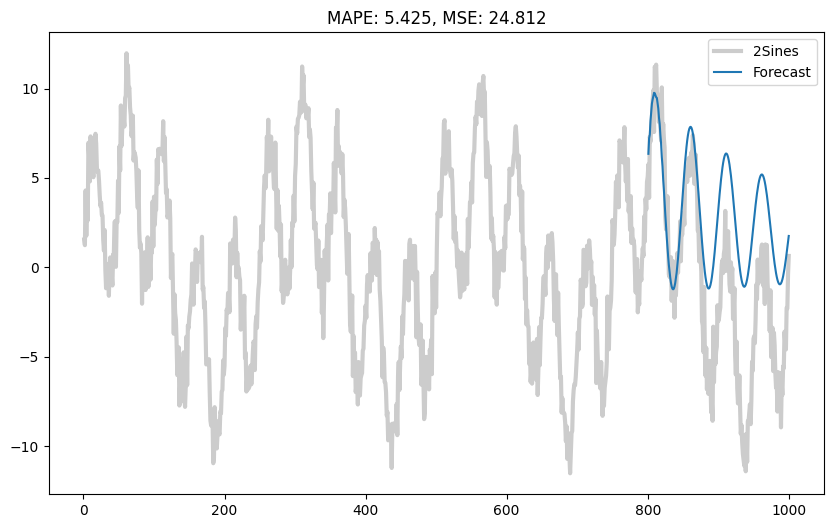

In [67]:
mape = MAPE(predictions, test_ar)
mse = MSE(predictions, test_ar)

plt.figure(figsize=(10,6))
plt.plot(ts['ds'], ts['data'], lw=3, alpha=0.2, c='k', label='2Sines')
plt.plot(ts['ds'].tail(n - ntrain), predictions, label='Forecast')
plt.title('MAPE: {:.3f}'.format(mape) + ', MSE: {:.3f}'.format(mse))
plt.legend()

plt.savefig("figAR_2")

plt.show()

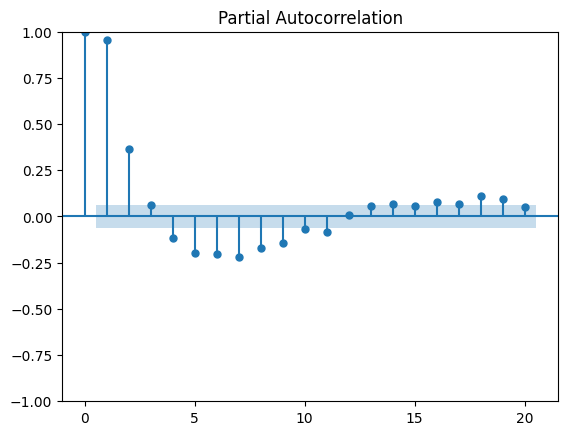

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts['data'], lags=20)
plt.show()